# Entanglement in Action

# Teleportation

In [1]:
%pip install qiskit[visualization]

  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached rustworkx-0.15.1-cp38-abi3

In [2]:
%pip install qiskit_aer

  Using cached qiskit_aer-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
Using cached qiskit_aer-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Required imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

## Create the Protocol

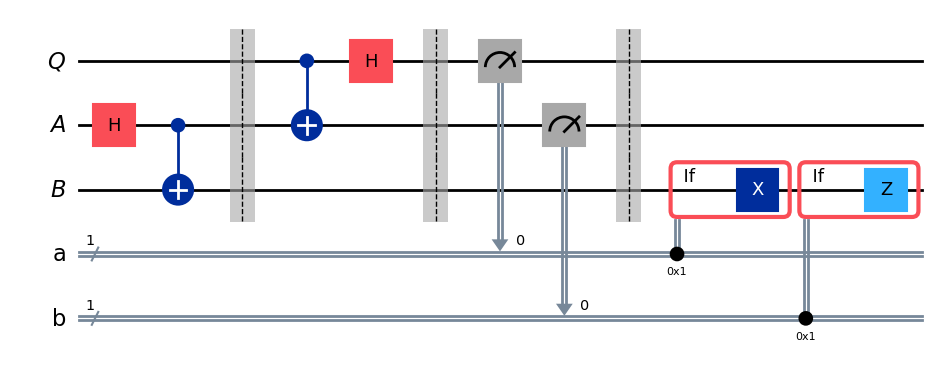

In [4]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
# Replace ?
protocol.h(ebit0)             # Apply Hadamard gate to Alice's qubit
protocol.cx(ebit0, ebit1)     # Apply CNOT gate from Alice's to Bob's qubit
protocol.barrier()

# Alice's operations
# Replace ?
protocol.cx(qubit, ebit0)     # Alice entangles her qubit with the ebit
protocol.h(qubit)             # Apply Hadamard gate on Alice's qubit
protocol.barrier()

# Alice measures and sends classical bits to Bob
# Replace?
protocol.measure(qubit, a)    # Measure Alice's qubit and store result in classical register a
protocol.measure(ebit0, b)    # Measure the entangled qubit and store result in classical register b
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
# Replace ? 
with protocol.if_test((a, 1)):
    protocol.x(ebit1)         # Apply X gate if Alice's measurement result a is 1
with protocol.if_test((b, 1)):
    protocol.z(ebit1)         # Apply Z gate if Alice's measurement result b is 1
    
display(protocol.draw('mpl'))

The circuit makes use of a few features of Qiskit
that require some explanations, including the barrier and if_test functions. 
The barrier function creates a visual separation making the circuit diagram more readable, 
and it also prevents Qiskit from performing various simplifications and optimizations across barriers 
during compilation when circuits are run on real hardware. 
The if_test function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes 
(A,B) to be in a 
∣ϕ+⟩
state (which is not part of the protocol itself), 
followed by Alice's operations, then her measurements, and finally Bob's operations.

## Test the Protocol

To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized 
∣0⟩ state of 
Q to obtain a random quantum state vector to be teleported. 
By applying the inverse (i.e., conjugate transpose) of that gate to 
B after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the 
∣0⟩
state.

First we'll randomly choose a unitary qubit gate.

In [5]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[-0.91172136+0.j        ,  0.4078565 -0.04916533j],
       [-0.31217036+0.26704648j, -0.61690014+0.67131964j]])

Now we'll create a new testing circuit that first applies our random gate to 
Q, then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit 
B and measures. The outcome should be 
0 with certainty.

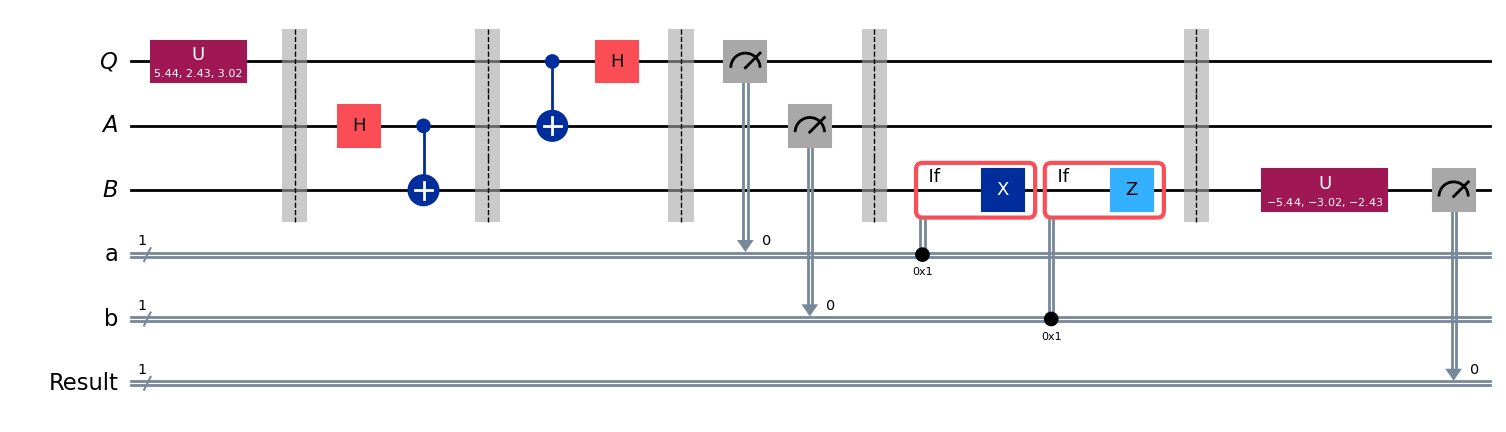

In [7]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
# Replace ?

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.
# Replace ?

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.
# Replace ?

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw('mpl'))

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits: the bottom/leftmost bit should always be 
0, indicating that the qubit 
Q was successfully teleported into 
B, while the other two bits should be roughly uniform.

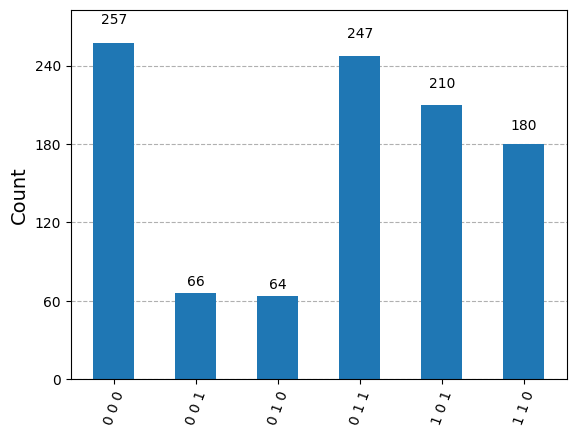

In [8]:
# Replace ?
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

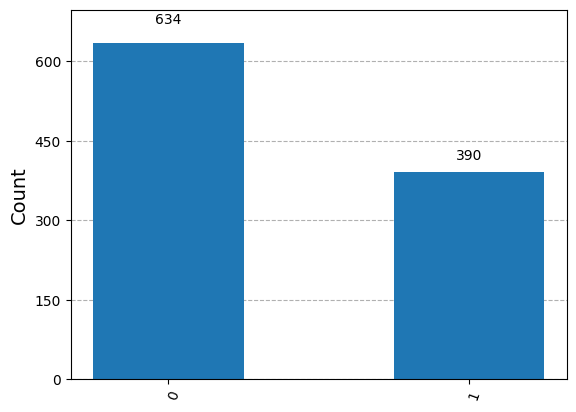

In [9]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

# End of Notebook